<a href="https://colab.research.google.com/github/libonill/spytorch/blob/master/SNN_tim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 

1.  We **set** the numbers of input, output, timeStep, batch_size, libraries!





In [0]:
nb_inputs  = 1
nb_outputs = 2

In [0]:
time_step = 1e-3
nb_steps  = 100

In [0]:
batch_size = 2

In [0]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [0]:
dtype = torch.float
device = torch.device("cpu")



2.   **Creating Data**, tensor batch_size x nb_steps x nb_inputs = 2x100x1









In [0]:
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[0][0][0]=1
x_data[0][1][0]=1
x_data[1][0][0]=1
x_data[1][9][0]=1



*   **Plot** of spike raster of the second input pattern!







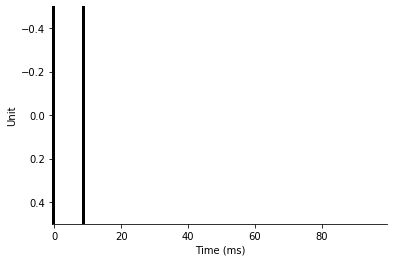

In [0]:
x_id = 1 
plt.imshow(x_data[x_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [0]:
# plt.plot(x_data[1])



*  **Label** for the two input patterns




In [0]:
y_data = torch.tensor([0,1])


In [0]:
y_data.shape

torch.Size([2])

3. **SETUP SNNs model**

*  SETUP OF THE SPIKING NEURAL NETWORK 




 LIF neuron model in discrete time!
 fix several model constants such as the membrane and the synaptic time constant. alpha and beta!

In [0]:
#tau_mem = 10e-3
#tau_syn = 5e-3

alpha   = 0 

beta_plastic = torch.empty(nb_outputs,  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(beta_plastic, mean=.9, std=.01)



tensor([0.9166, 0.8932], requires_grad=True)

* Setup **weights matrix** connect the input layer with the output layer. we initialize these weights randomly from a normal distribution! *we scale the variance with the inverse square root of the number of input connections.* The weights can be either excitatory or inhibitory.


In [0]:
#weight_scale = 7*(1.0-0.9) # this should give us some spikes to begin with


w1 = torch.empty((nb_inputs, nb_outputs),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=1.0, std=.1)

#w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
#torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

#print("init done")
w1

tensor([[0.9879, 0.9950]], requires_grad=True)

4. **AN SPIKING NEURAL NETWORK IN DICRETE TIME**

First we multiply all inputs spikes with the weight matrix! We have to do this for each time step in each input example in the batch. We get a tensor 2x100x2

In [0]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1))


These "weighted"input spikes  will now feed into our synaptic variable and ultimately the membrane potential.

*  For each trial. We initialize the synaptic currents and membrane potentials at zero.
To use our network as a classifier we need to have a **readout layer** on whose output we can define a cost function. 
 
we will build the output layer as a population of *leaky integrator neurons*. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their bretheren. 

Adding a readout layer...



In [0]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    
    syn = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_mem = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_mem_rec = [out_mem]
    for t in range(nb_steps):
        new_syn = alpha*syn +h1[:,t] # synaptic current
        new_out_mem = torch.einsum("ab,b->ab", (out_mem,beta_plastic)) +syn #membrane potential
        # new_out_mem = .9*out_mem +syn #membrane potential

        syn = new_syn
        out_mem= new_out_mem

        out_mem_rec.append(out_mem) 

    out_mem_rec = torch.stack(out_mem_rec,dim=1) # stack:Concatenates sequence of tensors along a new dimension. we merge the recorded membrane potentials into a single tensor
    return out_mem_rec

In [0]:
out_mem_rec = run_snn(x_data)
out_mem_rec.shape

torch.Size([2, 101, 2])

* Plot the membrane potencial 

In [0]:
def plot_voltage_traces(mem, spk=None, dim=(1,2), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

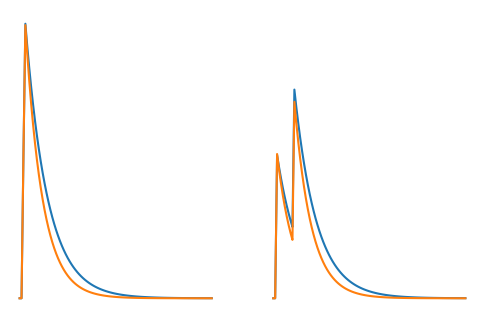

In [0]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_mem_rec)

In [0]:
def print_classification_accuracy():
    output= run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.500


---------------------------------------------------------This is practice--------------------------------------------------------------------------

In [0]:
w1

tensor([[0.9034, 1.1073]], requires_grad=True)

--------------------------------------------------------------------------------

5. **SUPERVISED LEARNING**

In [0]:

#params = [w1] # The paramters we want to optimize
params = [w1,beta_plastic] # The paramters we want to optimize

optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
for e in range(1000):
    # run the network and get output
    output = run_snn(x_data) 
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m) 
    loss_val = loss_fn(log_p_y, y_data)

    # update the weights
    optimizer.zero_grad() #backward()function accumulates gradients, Not to mix up gradients between minibatches. Have to zero them out at the start of a new minibatch. 
    loss_val.backward() # Gradients
    optimizer.step() #method that update the parameters
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    beta_plastic.data.clamp_(0.,1.)
    
loss_hist_true_grad = loss_hist # store for later use

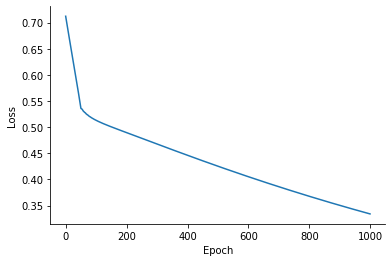

In [0]:

plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [0]:
print_classification_accuracy()

Accuracy 1.000


6. **OPTIMIZING THE TIME SCALES**

In [0]:
beta_plastic


tensor([0.7544, 1.0000], requires_grad=True)

In [0]:
w1

tensor([[2.2227, 1.5311]], requires_grad=True)

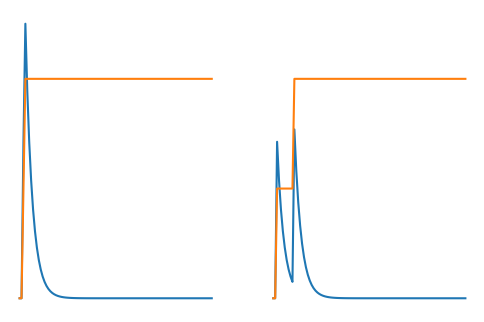

In [0]:
out_mem_rec = run_snn(x_data)
out_mem_rec.shape
fig=plt.figure(dpi=100)
plot_voltage_traces(out_mem_rec)

In [0]:
out_mem_rec.shape

torch.Size([2, 101, 2])